In [1]:
#import packages for numerics
import numpy as np
import xarray as xr
import glob
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.cluster import AgglomerativeClustering
from scipy import integrate, stats, optimize

#import packages for plotting
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as mpatches
import matplotlib.path as mpath

#import some custom tools
import sys
sys.path.insert(1, '/home/bertossa/')
import CS_C_extract.read_netcdf as CSCreader
from plotting_tools import NP_plots

#useful functions
def moving_average(a, n=2) :
    """simple sliding window running mean"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def clustercmap(n_cluster):
    """simple function to make a segmented colormap for a defined number of clusters"""
    from_list = matplotlib.colors.LinearSegmentedColormap.from_list
    cmap = plt.cm.Dark2
    my_cmap = cmap(np.arange(n_cluster))
    my_cmap[:,-1]= 1.
    cm = from_list(None, my_cmap, n_cluster)
    return cm

#some potentially useful functions for analyzing similarity of clusters
def area(curv1,curv2,bins):
    """find percentage of overlapping area between two curves"""
    inters_x = np.minimum(curv1, curv2)
    area_inters_x = np.trapz(inters_x, bins)*100.
    return area_inters_x

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read in just NH saved CloudSat-CALIPSO dataset
csds = CSCreader.read(lat_min=60, lat_max=90, drop_variables=['cthick'])
#csds = CSCreader.read(lat_min=-90, lat_max=-60,  drop_variables=['cthick','swcrfs','fsus','fsds','flut','fsut'])

#we'll use flds distributions to create the clusters
flds = csds.flds.values
lats = csds.longitude.values
lons = cscs.latitude.values


KeyboardInterrupt



In [ ]:
#regrid CloudSat-CALIPSO data onto 2x2 degree grid
dx=2
dy=2

#define bins
x_bins = np.arange(-180,180+dx, dx)
y_bins = np.arange(60., np.abs(csds.latitude.values).max()+dy, dy)

#use for SH
# y_bins *=-1
# y_bins = y_bins[::-1]

print(y_bins)
print(x_bins)
#use this function simply to aid with regridding, it returns indices of regridded data
means = stats.binned_statistic_2d(lons, lats, flds,
                                  statistic='mean', bins=[x_bins, y_bins])

In [ ]:
#Use a histogram for estimating FLDS PDF
histbins=np.arange(0.,450.1,5)
#array to hold pdfs for each gridbox
pdfs = np.empty(( (len(x_bins)-1)* (len(y_bins)-1), len(histbins)-1))

#simply finding the PDF (normalized) of our regridding CSC dataset
bins = np.unique(means.binnumber)
for ii,jj in tqdm(enumerate(bins)):
    #find matching locations to gridbox and compile for PDF
    locs = np.where( (means.binnumber==jj) ) [0]
    y,x = np.histogram(flds[locs], bins=histbins, density=True)
    #add to pdf array
    pdfs[ii,:]=y

# 1.1 For Arctic

In [46]:
n_cluster_save = 3#select ad hoc a certain cluster number to save data to netcdf

for n_cluster in [2,3,4,5,6]: #clusters we'll show examples for
      
    #main clustering routine, use average linkage euclidien distance.
    clusters = AgglomerativeClustering(
        n_clusters=n_cluster,linkage='average').fit_predict(pdfs) #cluster on normalized PDFs 
    
    
    if n_cluster == 2:
        clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
    if n_cluster == 4:
        clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
    if n_cluster == 5:
        where_0 = np.where(clusters== 0)
        where_1 = np.where(clusters== 2)
        clusters[where_0]=2
        clusters[where_1]=0
        
        
    
    #for plot 2, finding the PDFs of compiled regions (clusters)
    pdfs_compiled=np.empty((n_cluster,len(histbins)-1))
    #note the best way to do this is to compile all obs for each cluster and rederive PDF
    for jj in range(n_cluster): #iterate through each one of our cluster indices
        #find locations where indices match
        binnums = bins[np.where(clusters==jj)[0]]
        locs= np.array([np.where( (means.binnumber== cerbin) )[0] for cerbin in binnums], dtype=object)
        locs=np.concatenate(locs).ravel().astype(int)
       
        #compile the FLDS observations of these locations and plot a histogram
        pdfs_jj,x = np.histogram(flds[locs].reshape(-1,1), bins=histbins, density=True)
        #save histogram for later use
        pdfs_compiled[jj,:] = pdfs_jj      
        
        
        if n_cluster == n_cluster_save: #we'll save the cluster that we want to use for later
            ds = xr.Dataset(
            {
                "flds" : (["nray"], np.array(csds.flds)[locs]),
                "lwcrfs" : (["nray"], np.array(csds.lwcrfs)[locs]),
                "fsds" : (["nray"], np.array(csds.fsds)[locs]),
                "fsdsnc" : (["nray"], np.array(csds.fsdsnc)[locs]),
                "flut" : (["nray"], np.array(csds.flut)[locs]),
                "flutnc" : (["nray"], np.array(csds.flutnc)[locs]),
                "fsut" : (["nray"], np.array(csds.fsut)[locs]),
                "fsutnc" : (["nray"], np.array(csds.fsutnc)[locs]),
                "cphase" : (["nray"], np.array(csds.cphase)[locs]),
                "sfctype": (["nray"], np.array(csds.sfctype)[locs]),
                "cbase"  : (["nray"], np.array(csds.cbase)[locs]),
                "ctop"   : (["nray"], np.array(csds.ctop)[locs]),
                "ascending"   : (["nray"], np.array(csds.ascending)[locs]),
                "DEM" : (["nray"], np.array(csds.DEM)[locs]),
                
            },
            coords = {
                'timestamp' :(['nray'], np.array(csds.timestamp)[locs]),
                'longitude': (['nray'], np.array(csds.longitude)[locs]),
                'latitude' : (['nray'], np.array(csds.latitude)[locs]),
            },
            )
            #save particualr clsuter to netcdf
            ds.to_netcdf('/doppler/data8/bertossa/m01_clusters/2x2deg_{}clusters_c{}_Arc.nc'.format(n_cluster_save,jj))
            
    #save actual locations and histograms to numpy array for plotting later
    np.save('./clustering_ids/{}clusters_2x2deg_Arc'.format(n_cluster), clusters.reshape(means.statistic.shape).T)
    np.save('./clustering_ids/{}clusters_pdfs_Arc'.format(n_cluster), pdfs_compiled)

# Plotting

2
3
4
5
6


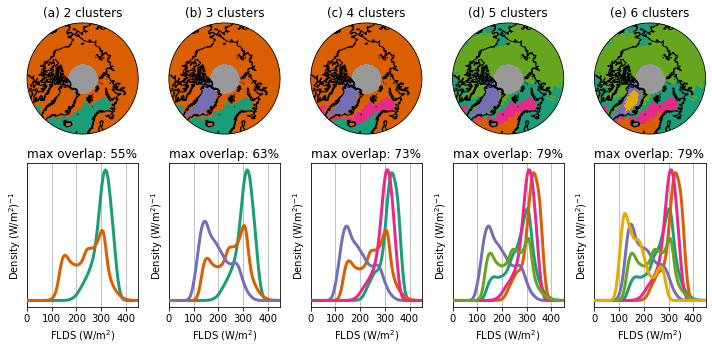

In [3]:
ax_labels = ['(a)','(b)','(c)','(d)','(e)','(f)', '(g)', '(h)', '(i)', '(j)','(k)','(l)']
fig = plt.figure(figsize=(10,5))

#data to add a mask for 82-90N, where CSC doesn't observe
mlons = np.arange(-180,181,5.)
mlats = np.arange(81.,91.,1.)
msk = np.zeros((len(mlats),len(mlons)))

kk=1 #subplot indices
for n_cluster in [2,3,4,5,6]: #clusters we'll show examples for
    print(n_cluster)
    
    ax=fig.add_subplot(2,5,kk, projection= ccrs.NorthPolarStereo()) #subplot for plotting the cluster locations
    
    ax2=fig.add_subplot(2,5,kk+5) #subplot for plotting the PDFs
    
    #retrieve cluster lcoations
    clusters = np.load('./clustering_ids/{}clusters_2x2deg_Arc.npy'.format(n_cluster))
    cm = clustercmap(n_cluster) #get colormap to plot clusters
        
    #plot 1 of cluster locations
    cen_lons, cen_lats = moving_average(x_bins),moving_average(y_bins) #gridbox locs

    cf=ax.pcolormesh(cen_lons, cen_lats, clusters, cmap=cm, transform = ccrs.PlateCarree()) 
    
    #touch ups to mask out 82-90N where CSC doesn't observe, and make circular plots
    NP_plots.make_ax_circular(ax)
    ax.contourf(lons, lats , msk, colors='gray',
                         alpha=0.8, transform=ccrs.PlateCarree(),zorder=-5)
    
    ax.set_extent([-180,180,60.5,90], crs = ccrs.PlateCarree())
    ax.set_title('{} {} clusters'.format(ax_labels[kk-1],n_cluster))
    
    #retrieve PDFs for histogram plotting
    pdfs = np.load('./clustering_ids/{}clusters_pdfs_Arc.npy'.format(n_cluster))
    
    for jj in range(n_cluster):
        pdfs_jj = pdfs[jj,:]
        ysmoothed = gaussian_filter1d(pdfs_jj, sigma=1.5) # a little smoothing to make plot less noisy
        ax2.plot(moving_average(histbins), ysmoothed, alpha=1.0, color=cm(jj), linewidth=3,zorder=100)
    
    #compute amount of overlapping area matrix (has shape, (n_cluster, ncluster)), diagonal should be 100%
    dm = np.asarray([[area(p1, p2, moving_average(histbins)) for p2 in pdfs] for p1 in pdfs])
    #axes adjustments
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(0.,500,100.))
    ax2.set_xlim(0.,450.)
    ax2.set_xlabel('FLDS (W/m$^2$)')
    ax2.set_ylabel('Density (W/m$^2$)$^{-1}$')
    
    #select the maximum overlapping area to show most similar dists. (not 100%, this is w itself)
    ax2.set_title('max overlap: {}%'.format(int(np.max(dm[dm<99.99]))), loc='left')
    kk+=1
    plt.grid()
    
fig.savefig('./plots/01_Arc_clustering.png',dpi =300, bbox_inches='tight')        
plt.tight_layout()
    

# 2.1 For Antarctic

In [14]:
n_cluster_save = 300#select ad hoc a certain cluster number to save data to netcdf

for n_cluster in [2,3,4,5,6]: #clusters we'll show examples for
      
    clusters = AgglomerativeClustering(n_clusters=n_cluster,linkage='average').fit_predict( 
        pdfs.reshape((len(x_bins)-1)* (len(y_bins)-1),-1) ) #cluster on normalized PDFs 
    
    if n_cluster == 2:
        clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
    if n_cluster == 4:
        clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
    if n_cluster == 6:
        where_0 = np.where(clusters== 0)
        where_1 = np.where(clusters== 2)
        clusters[where_0]=2
        clusters[where_1]=0
        
    
    #for plot 2, finding the PDFs of compiled regions (clusters)
    pdfs_compiled=np.empty((n_cluster,len(histbins)-1))
    for jj in range(n_cluster): #iterate through each one of our cluster indices
        #find locations where indices match
        binnums = bins[np.where(clusters==jj)[0]]
        locs= np.array([np.where( (means.binnumber== cerbin) )[0] for cerbin in binnums], dtype=object)
        locs=np.concatenate(locs).ravel().astype(int)
       
        #compile the FLDS observations of these locations and plot a histogram
        pdfs_jj,x = np.histogram(flds[locs].reshape(-1,1), bins=histbins, density=True)
        
        pdfs_compiled[jj,:] = pdfs_jj      
        
        
        if n_cluster == n_cluster_save: #we'll save the cluster that we want to use for later
            ds = xr.Dataset(
            {
                "flds" : (["nray"], np.array(csds.flds)[locs]),
                "lwcrfs" : (["nray"], np.array(csds.lwcrfs)[locs]),
                "fsds" : (["nray"], np.array(csds.fsds)[locs]),
                "fsdsnc" : (["nray"], np.array(csds.fsdsnc)[locs]),
                "flut" : (["nray"], np.array(csds.flut)[locs]),
                "flutnc" : (["nray"], np.array(csds.flutnc)[locs]),
                "fsut" : (["nray"], np.array(csds.fsut)[locs]),
                "fsutnc" : (["nray"], np.array(csds.fsutnc)[locs]),
                "cphase" : (["nray"], np.array(csds.cphase)[locs]),
                "sfctype": (["nray"], np.array(csds.sfctype)[locs]),
                "cbase"  : (["nray"], np.array(csds.cbase)[locs]),
                "ctop"   : (["nray"], np.array(csds.ctop)[locs]),
                "ascending"   : (["nray"], np.array(csds.ascending)[locs]),
                "DEM" : (["nray"], np.array(csds.DEM)[locs]),
                
            },
            coords = {
                'timestamp' :(['nray'], np.array(csds.timestamp)[locs]),
                'longitude': (['nray'], np.array(csds.longitude)[locs]),
                'latitude' : (['nray'], np.array(csds.latitude)[locs]),
            },
            )

            ds.to_netcdf('/doppler/data8/bertossa/m01_clusters/2x2deg_{}clusters_c{}_AA.nc'.format(n_cluster_save,jj))
            
    #save actual locations to numpy array
    np.save('./clustering_ids/{}clusters_2x2deg_AA'.format(n_cluster), clusters.reshape(means.statistic.shape).T)
    np.save('./clustering_ids/{}clusters_pdfs_AA'.format(n_cluster), pdfs_compiled)

2
3
4
5
6


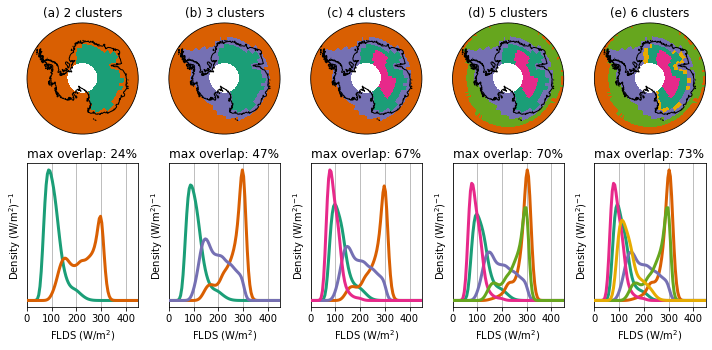

In [4]:
def area(curv1,curv2,bins):
    inters_x = np.minimum(curv1, curv2)
    area_inters_x = np.trapz(inters_x, bins)*100.
    return area_inters_x

ax_labels = ['(a)','(b)','(c)','(d)','(e)','(f)', '(g)', '(h)', '(i)', '(j)','(k)','(l)']
fig = plt.figure(figsize=(10,5))

kk=1 #subplot indices

dx=2
dy=2

x_bins = np.arange(-180,180+dx, dx)
y_bins = np.arange(60.,82+dx, dy)
histbins=np.arange(0.,450.1,5)

y_bins *=-1
y_bins = y_bins[::-1]
lons = np.arange(-180,181,5.)
lats = np.arange(81.,91.,1.)
msk = np.zeros((lats.shape[0],lons.shape[0]))

for n_cluster in [2,3,4,5,6]: #clusters we'll show examples for
    print(n_cluster)
    
    ax=fig.add_subplot(2,5,kk, projection= ccrs.SouthPolarStereo()) #subplot for plotting the cluster locations
    
    ax2=fig.add_subplot(2,5,kk+5) #subplot for plotting the PDFs
    
    clusters = np.load('./clustering_ids/{}clusters_2x2deg_AA.npy'.format(n_cluster))
    cm = clustercmap(n_cluster) #get colormap to plot clusters
    
#     if n_cluster == 2:
#         clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
#     if n_cluster == 4:
#         clusters=np.where((clusters==0)|(clusters==1), clusters^1,clusters)
        
#     if n_cluster == 6:
#         where_0 = np.where(clusters== 0)
#         where_1 = np.where(clusters== 2)
#         clusters[where_0]=2
#         clusters[where_1]=0
        
        
#         temp = clusters
#         clusters=0
#         clusters[[np.where(temp==0.)[0]]=1]
        
    #plot 1 of cluster locations
    cen_lons, cen_lats = moving_average(x_bins),moving_average(y_bins) #gridbox locs

    cf=ax.pcolormesh(cen_lons, cen_lats, clusters, cmap=cm, transform = ccrs.PlateCarree()) 
    

    #touch ups to mask out 82-90N where CSC doesn't observe, and make circular plots
    NP_plots.make_ax_circular(ax)
    ax.contourf(lons, lats , msk, colors='gray',
                         alpha=0.8, transform=ccrs.PlateCarree(),zorder=-5)
    
    ax.set_extent([-180,180,-90,-60.5], crs = ccrs.PlateCarree())
    ax.set_title('{} {} clusters'.format(ax_labels[kk-1],n_cluster))
    
    pdfs = np.load('./clustering_ids/{}clusters_pdfs_AA.npy'.format(n_cluster))
    
    for jj in range(n_cluster):
        pdfs_jj = pdfs[jj,:]
        ysmoothed = gaussian_filter1d(pdfs_jj, sigma=1.5) # a little smoothing to make plot less noisy
        ax2.plot(moving_average(histbins), ysmoothed, alpha=1.0, color=cm(jj), linewidth=3,zorder=100)
        
    dm = np.asarray([[area(p1, p2, moving_average(histbins)) for p2 in pdfs] for p1 in pdfs])
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(0.,500,100.))
    ax2.set_xlim(0.,450.)
    ax2.set_xlabel('FLDS (W/m$^2$)')
    ax2.set_ylabel('Density (W/m$^2$)$^{-1}$')
    ax2.set_title('max overlap: {:.0f}%'.format(int(np.max(dm[dm<99.99]))), loc='left')
    kk+=1
    plt.grid()
fig.savefig('./plots/01_AA_clustering.png',dpi =300, bbox_inches='tight')    
plt.tight_layout()
    